In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
plt.ion()


import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed

from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspologic.plot import heatmap
from sklearn.manifold import Isomap
import piecewise_regression
from sklearn.linear_model import LinearRegression


from kneed import DataGenerator, KneeLocator

def filter_matrix_TC(data, well):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well]['win_0']['adj_matrix_predicted']
    votes = data[well]['win_0']['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well]['win_0']['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix


import warnings

def find_optimal_neighbors(X):
    n_neighbors = 2
    while True:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                isomap = Isomap(n_neighbors=n_neighbors)
                isomap.fit(X)
                print(f"Successful with n_neighbors={n_neighbors}")
                return n_neighbors
        except Warning as w:
            print(f"Warning encountered with n_neighbors={n_neighbors}: {w}")
            n_neighbors += 1




from scipy.stats import norm

def get_elbows(dat, n=3, threshold=False, plot=True, main=""):
    """
    Given a decreasingly sorted vector, return the given number of elbows.

    Args:
        dat: an input vector (e.g. a vector of standard deviations) or an input feature matrix.
        n: the number of returned elbows.
        threshold: either False or a number. If threshold is a number, then all
                   the elements in dat that are not larger than the threshold will be ignored.
        plot: logical. When True, it depicts a scree plot with highlighted elbows.
        main: title for the plot.

    Returns:
        q: a list of length n containing the positions of the elbows.
    """
    
    if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
        d = np.sort(np.std(dat, axis=0))[::-1]
    else:
        d = np.sort(dat)[::-1]

    if threshold is not False:
        d = d[d > threshold]

    p = len(d)
    if p == 0:
        raise ValueError(f"d must have elements that are larger than the threshold {threshold}!")

    lq = np.zeros(p)  # log likelihood, function of q
    for q in range(p):
        mu1 = np.mean(d[:q+1])
        mu2 = np.mean(d[q+1:]) if q < p-1 else np.nan
        sigma2 = (np.sum((d[:q+1] - mu1)**2) + np.sum((d[q+1:] - mu2)**2)) / (p - 1 - (q < p-1))
        lq[q] = (np.sum(norm.logpdf(d[:q+1], mu1, np.sqrt(sigma2))) + 
                 np.sum(norm.logpdf(d[q+1:], mu2, np.sqrt(sigma2))))

    q = [np.argmax(lq)]
    if n > 1 and q[0] < (p - 1):
        q.extend([q[0] + 1 + el for el in get_elbows(d[q[0]+1:], n-1, plot=False)])

    if plot:
        if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
            sdv = d
            plt.plot(sdv, marker='o')
            plt.xlabel("dim")
            plt.ylabel("stdev")
            plt.title(main)
            plt.scatter(q, sdv[q], s=100, color='red')
        else:
            plt.plot(dat, marker='o')
            plt.title(main)
            plt.scatter(q, dat[q], s=100, color='red')
        plt.show()

    return q



##  Week 5.5 to 8.5 (run 8 and LD)/LD Chip M5898 ('well003', 'win_0', 932.8, 44232.2) 

In [2]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/2024May28 No window data /OneDrive_1_6-17-2024/TimeCourseData_ecr_results/Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8'
#dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/March 30 2024/TimeCourseData_ecr_results_windowed/Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8'
#dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/March 30 2024/TimeCourseData_ecr_results_windowed/Raw Data Week 9.5 to 12.5 (run 6 and 7)/Run 7'
os.chdir(dr)

In [3]:
filenames=os.listdir(dr)
filenames.pop(2)
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('DIV ')[1]))
#sorted_filenames_updated = [filename + '/data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
sorted_filenames_updated = [filename + '/data.raw_20240521_17h07m.pkl' for filename in sorted_filenames]
#sorted_filenames_updated = [filename + '/M05912data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
sorted_filenames_updated


['DIV 3/data.raw_20240521_17h07m.pkl',
 'DIV 5/data.raw_20240521_17h07m.pkl',
 'DIV 7/data.raw_20240521_17h07m.pkl',
 'DIV 9/data.raw_20240521_17h07m.pkl',
 'DIV 11/data.raw_20240521_17h07m.pkl',
 'DIV 13/data.raw_20240521_17h07m.pkl',
 'DIV 15/data.raw_20240521_17h07m.pkl',
 'DIV 17/data.raw_20240521_17h07m.pkl',
 'DIV 19/data.raw_20240521_17h07m.pkl',
 'DIV 21/data.raw_20240521_17h07m.pkl']

In [12]:
## This shows that the data doesn't have window 
with open(sorted_filenames_updated[0], 'rb') as f:
    data = pkl.load(f)
data['well000'].keys()

dict_keys(['spike_amp_thresh', 'channel_numbers', 'channel_spikes_per_sec', 'win_0'])

In [4]:
well='well004'

In [5]:
## read in all the time series of graphs
all_adj = []
num_vertices = []
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    adj = filter_matrix_TC(data, well)
    all_adj.append(adj)
    num_vertices.append(adj.shape[0])

total_edges = 0
total_matrices = len(all_adj)

for adj in all_adj:
    total_edges += adj.sum()

average_edges = total_edges / total_matrices
print("Average number of edges:", average_edges)

Average number of edges: 49084.6


In [11]:
## add zeros to the adj mat such that they have the same dims 
dim = max(num_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 
    
graph_matching=True

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

Frob diff before GM: 12.489995996796797, After GM: 12.489995996796797,OFV before GM: 0.0, After GM: 0.0
Frob diff before GM: 23.194827009486403, After GM: 17.204650534085253,OFV before GM: 0.0, After GM: 121.0
Frob diff before GM: 32.848135411313685, After GM: 24.596747752497688,OFV before GM: 0.0, After GM: 237.0
Frob diff before GM: 74.34379597518544, After GM: 65.67343450741707,OFV before GM: 1.0, After GM: 608.0
Frob diff before GM: 170.48167056900868, After GM: 143.7289114966088,OFV before GM: 63.0, After GM: 4266.0
Frob diff before GM: 325.31523173684934, After GM: 264.69605210505125,OFV before GM: 1910.0, After GM: 19793.0
Frob diff before GM: 423.8997522999984, After GM: 246.91901506364388,OFV before GM: 8089.0, After GM: 67450.0
Frob diff before GM: 467.69755184306877, After GM: 273.1940702138317,OFV before GM: 16118.0, After GM: 88171.0
Frob diff before GM: 481.0945852948254, After GM: 270.3701166919155,OFV before GM: 16550.0, After GM: 95726.0


In [17]:
choosen_time_points=range(1,10)
tm=choosen_time_points

D=np.zeros([len(tm),len(tm)])

ASE embedding dim 8 50
ASE embedding dim 6 37
ASE embedding dim 5 36
ASE embedding dim 8 45
ASE embedding dim 8 47
ASE embedding dim 8 47
ASE embedding dim 8 47
ASE embedding dim 8 48
ASE embedding dim 8 46
ASE embedding dim 12 90
ASE embedding dim 12 80
ASE embedding dim 12 75
ASE embedding dim 12 84
ASE embedding dim 12 88
ASE embedding dim 12 87
ASE embedding dim 12 87
ASE embedding dim 12 87
ASE embedding dim 28 120
ASE embedding dim 28 120
ASE embedding dim 30 119
ASE embedding dim 30 119
ASE embedding dim 27 118
ASE embedding dim 27 117
ASE embedding dim 28 118
ASE embedding dim 2 249
ASE embedding dim 2 244
ASE embedding dim 2 236
ASE embedding dim 2 238
ASE embedding dim 2 240
ASE embedding dim 2 230
ASE embedding dim 2 488
ASE embedding dim 2 486
ASE embedding dim 2 470
ASE embedding dim 2 460
ASE embedding dim 2 448
ASE embedding dim 2 805
ASE embedding dim 2 791
ASE embedding dim 2 770
ASE embedding dim 2 733
ASE embedding dim 2 877
ASE embedding dim 2 874
ASE embedding dim 

<AxesSubplot:title={'center':'Distance matrix between time points'}>

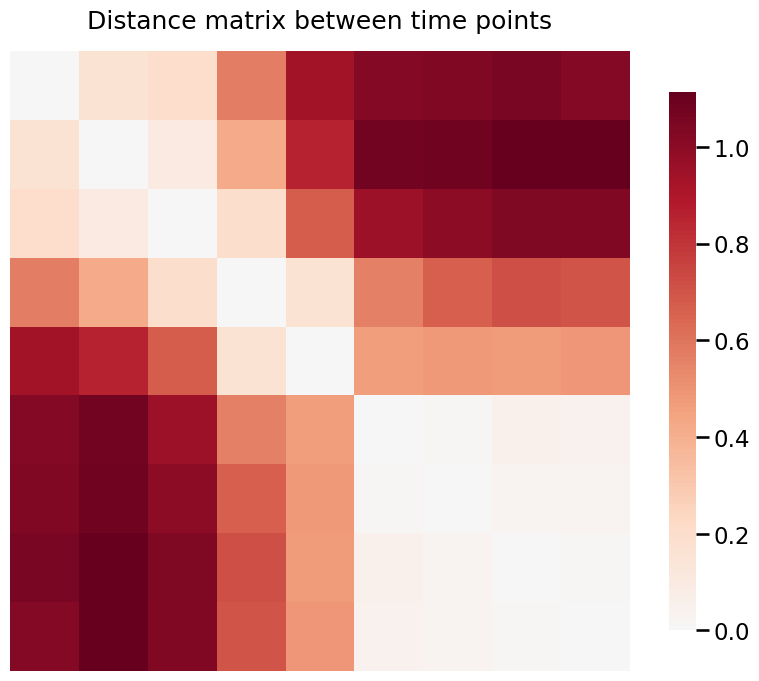

In [18]:
Pairwise_lccc=True
for i in range(len(tm)):
    for j in range(i,len(tm)):
        prod=adj_gm[choosen_time_points[i]] * adj_gm[choosen_time_points[j]]
        [a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
        n=len(ind)
        #print(i,j,n)
        glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
        glist[i]=adj_gm[choosen_time_points[i]][ind][:,ind]
        glist[j]=adj_gm[choosen_time_points[j]][ind][:,ind]
        #print(graspologic_utils.is_fully_connected(glist[i]))

        #if n<ed_old:
        #    ed=int(ed_old/3)
        #    print("ASE embedding dim",ed)
        

        s = np.linalg.svd(glist[i], compute_uv=False)
        #kneedle=KneeLocator(range(glist[i].shape[0]),s, curve="convex", direction="decreasing")
        #ed=kneedle.knee
        ed=get_elbows(s, n=1, plot=False)[0]+1
        print("ASE embedding dim",ed,n)

        Xhat_list=np.zeros([len(tm),n,2*ed])
        ase = AdjacencySpectralEmbed(n_components=ed)
        Xhat, Yhat = ase.fit_transform(glist[i])
        Xhat_list[i][:,list(np.arange(ed))]=Xhat
        Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

        Xhat, Yhat = ase.fit_transform(glist[j])
        Xhat_list[j][:,list(np.arange(ed))]=Xhat
        Xhat_list[j][:,list(np.arange(ed,2*ed))]=Yhat

        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  #Frobenius norm

D=D+D.T
heatmap(D, title="Distance matrix between time points")

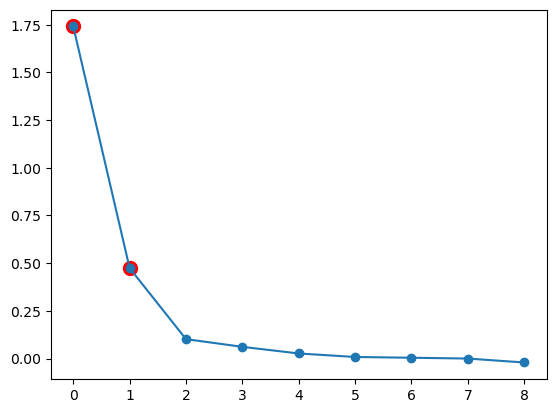

CMDS embedding dim: 2


In [20]:
## CMDS
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
#plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
#plt.xlabel('dimension',fontsize=15)
#plt.ylabel('eigen value',fontsize=15)
#kneedle=KneeLocator(range(len(tm)),w, curve="convex", direction="decreasing")
d=get_elbows(w, n=2, plot=True)[1]+1
print("CMDS embedding dim:", d)
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

In [25]:
time_diff_chosen = [ 5, 7, 9, 11, 13, 15, 17, 19, 21]

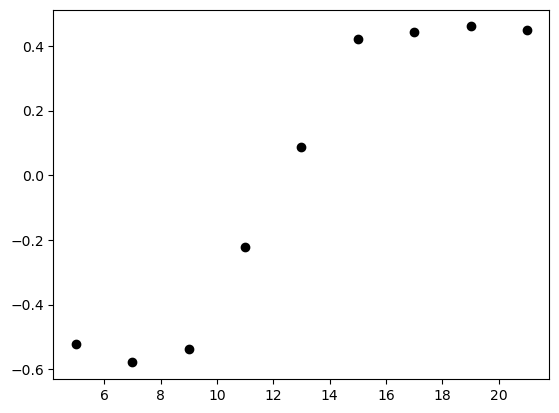

In [28]:
plt.scatter(time_diff_chosen,-MDS[:,0],color='black')

Text(0, 0.5, 'dim 2')

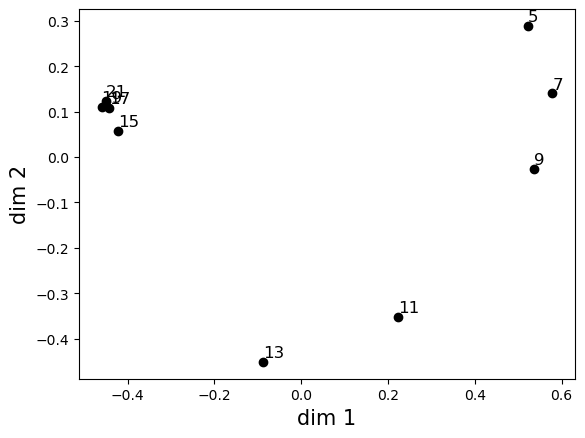

In [31]:
plt.scatter(MDS[:,0],-MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],-MDS[i,1]+0.01,int(time_diff_chosen[i]), fontsize=12)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

Successful with n_neighbors=2


Text(0.5, 1.0, 'Iso-mirror of well=well004 graph_matching=True Pairwise_lccc=True')

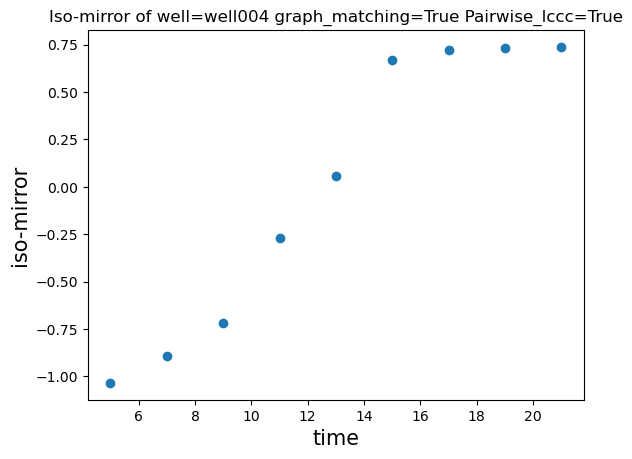

In [33]:
## ISOMAP fitting on CMDS result

optimal_n_neighbors = find_optimal_neighbors(MDS)
embedding = Isomap(n_neighbors=optimal_n_neighbors,n_components=1)
iso = embedding.fit_transform(MDS)
iso=iso[:,0]

if iso[0]>0:
    iso=-iso
else:
    iso=iso  

plt.scatter(time_diff_chosen,iso)
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)
plt.title("Iso-mirror of well=" + str(well)+' graph_matching='+str(graph_matching)+' Pairwise_lccc='+str(Pairwise_lccc))


In [12]:
sort_filename

array([[3, None, None],
       [5, None, None],
       [7, None, None],
       [9, None, None],
       [11, None, None],
       [13, None, None],
       [15, None, None],
       [17, None, None],
       [19, None, None],
       [21, None, None]], dtype=object)

In [13]:
for i in range(0,m):
    mat_data = all_adj[i]
    sort_filename[i,1]=(mat_data.shape[0])
    sort_filename[i,2]=(sum(sum(mat_data>0)))

In [14]:
sort_filename

array([[3, 443, 1],
       [5, 860, 29],
       [7, 963, 589],
       [9, 1000, 1415],
       [11, 1006, 18351],
       [13, 1010, 54048],
       [15, 1010, 84279],
       [17, 1009, 97738],
       [19, 1014, 95052],
       [21, 1013, 90820]], dtype=object)

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


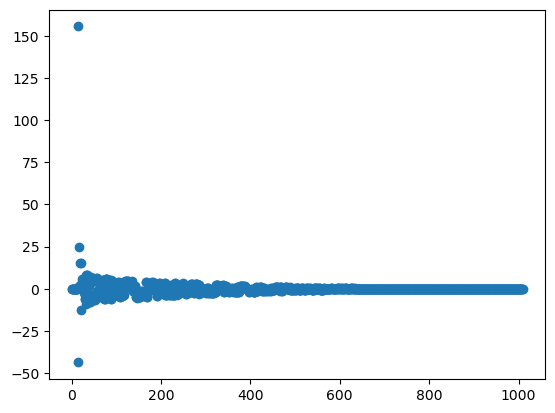

In [13]:
s,u=np.linalg.eig(all_adj[5])
plt.scatter(range(all_adj[5].shape[0]),s)

In [15]:
tm = [4,5,6,7,8,9]  

In [25]:
## add zeros to the adj mat such that they have the same dims 
dim = max(sort_filename[tm, 1])  # Max number of vertices to determine dimension
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size

for i in range(len(tm)):
    ma = all_adj[tm[i]]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [26]:
all_adj[5]

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [27]:
from scipy.optimize import quadratic_assignment
from numpy import linalg as LA

In [33]:
adj_gm=np.zeros([len(tm),dim,dim]) ## use the first graph as baseline
adj_gm[0] = adj_aug[0] 

In [29]:
dim

1014

In [34]:
for i in range(1, len(tm)):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm}")


Frob diff before GM: 263.40273347101015, After GM: 203.58045092788257
Frob diff before GM: 357.783454061252, After GM: 251.52534663528445
Frob diff before GM: 406.2893057908367, After GM: 280.34086394958547
Frob diff before GM: 418.3180608101926, After GM: 286.2271824967014
Frob diff before GM: 411.6527662970334, After GM: 283.6370920736567


In [35]:
## find largest common connected component 
prod=adj_gm[0]
for i in range(1,len(tm)):
    prod=prod * adj_gm[i]

In [36]:
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils

In [38]:
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)

358

In [42]:
n=len(ind)

In [40]:
# double check every adj mat is connected 
glist=np.zeros([len(tm),len(ind),len(ind)])
for i in range(len(tm)):
    glist[i]=adj_gm[i][ind][:,ind]
    print(graspologic_utils.is_fully_connected(glist[i]))

True
True
True
True
True
True


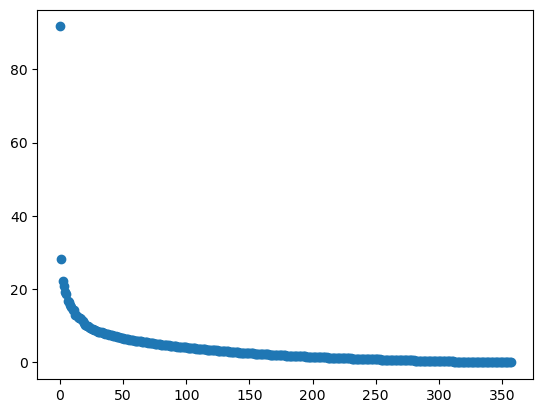

In [43]:
## scree plot for one graph 
u,s,v=np.linalg.svd(glist[0], full_matrices=True)
plt.scatter(range(n),s)

In [44]:
from graspologic.embed import AdjacencySpectralEmbed

In [86]:
ed=4
Xhat_list=np.zeros([len(tm),n,2*ed])
for i in range(len(tm)):
    ase = AdjacencySpectralEmbed(n_components=ed)
    Xhat, Yhat = ase.fit_transform(glist[i])
    Xhat_list[i][:,list(np.arange(ed))]=Xhat
    Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

In [87]:
from scipy.linalg import orthogonal_procrustes
D=np.zeros([len(tm),len(tm)])
for i in range(len(tm)):
    for j in range(len(tm)):
        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  

In [88]:
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

Text(0, 0.5, 'eigen value')

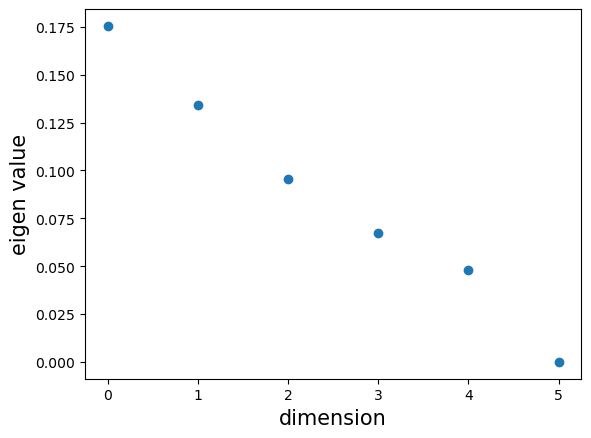

In [89]:
H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

In [90]:
d=4
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

In [91]:
## transform date to days from begining
day=np.zeros([len(tm)])
for i in range(len(tm)):
    day[i]=(sort_filename[tm[i],0]-sort_filename[tm[0],0])

Text(0, 0.5, 'dim 2')

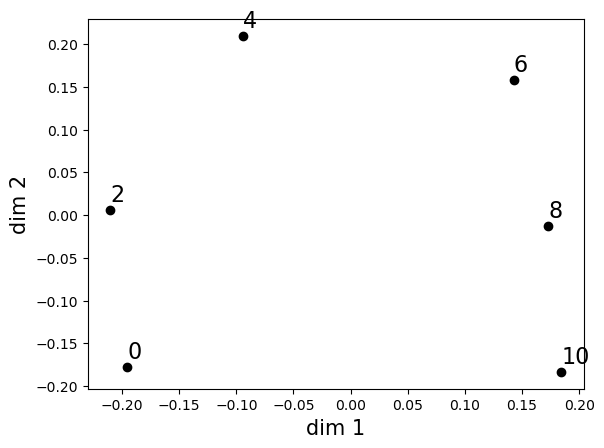

In [92]:
plt.scatter(MDS[:,0],MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],MDS[i,1]+0.01,str(int(day[i])), fontsize=16)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [93]:
from sklearn.manifold import Isomap

In [96]:
embedding = Isomap(n_neighbors=2,n_components=1)
iso = embedding.fit_transform(MDS)

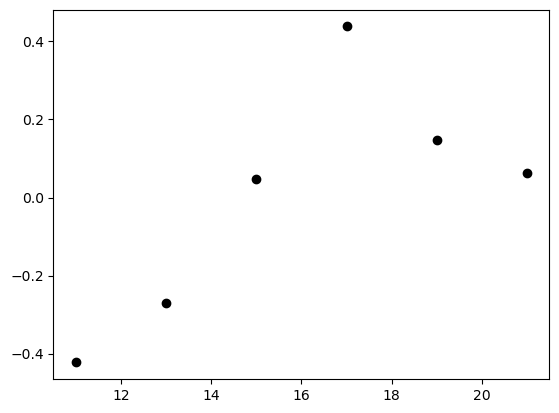

In [98]:
plt.scatter(day+11,iso,color='black')

[4, 5, 6, 7, 8, 9]